In [1]:
# Importing modules and libraries
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import matplotlib.colors as mcolors
from pyvis.network import Network
import webbrowser
import plotly.graph_objects as go
import numpy as np
from scipy.cluster.hierarchy import linkage, leaves_list
from IPython.display import HTML, display, IFrame, Markdown
import seaborn as sns

In [2]:
# Load into DataFrame
csv_path = '/lustre/b192aa/b192aa36/input/pagerank_merged.csv'
df = pd.read_csv(csv_path)

# Preview
df.head()

,paper_id,pagerank,fields_of_study
0,79b1c84af0aea452e8bbfbff8f5ef35edd1e0ceb,1.485953e-08,Chemistry
1,43981a8e26a5a82f6f852f9fb1734e716663a65b,1.413465e-08,Chemistry
2,df66e8bedee9eb79034acfb5c906f8af2ba1c7eb,1.572851e-08,Materials Science
3,02a6d1c7f945b25de94c34e92728ebbf30588a2f,1.457660e-08,Materials Science
4,67cbec764dbac45934787af7b5a78d0de58ac67e,1.513142e-08,Physics


In [3]:
df['pagerank'] = df['pagerank'].astype(float)

In [4]:
df['pagerank_scaled'] = (df['pagerank'] * 1e6).round(2)
# Add a “rank” column (highest PageRank gets rank 1)
df['rank'] = (
    df['pagerank']
    .rank(method='min', ascending=False)
    .astype(int)
)

In [5]:
path2 = '/lustre/b192aa/b192aa36/input/papers_by_authors.csv'
professors_df = pd.read_csv(path2, header=None)
print(professors_df.head())

          0           1                                         2  \
0  authorId  authorName                                   paperId   
1  50706060   M. Oliver  9fde2ca8f3ac0a5a543d7249092a7259b4f0cf55   
2  50706060   M. Oliver  077fba5d29c3c1ad0057c5f508dd7bad4a60d8aa   
3  50706060   M. Oliver  15ceedba62972fa35ec93940e2922dc400b36b5a   
4  50706060   M. Oliver  3df77554df51ec50d9c9b2a56c7a624544589fea   

                                                   3  \
0                                              title   
1  Advancing eddy parameterizations: Dynamic ener...   
2  On the Relation between Fourier and Walsh--Rad...   
3  Quasi-convergence of an implementation of opti...   
4  Advancing the simulation of mesoscale eddies: ...   

                                     4  
0                        fieldsOfStudy  
1                                  NaN  
2                                  NaN  
3  ['Computer Science', 'Mathematics']  
4                          ['Geology']  


In [6]:
# Columns aren't named properly. Rename them and drop the first row
professors_df.columns = ['authorId', 'authorName', 'paperId', 'title', 'fieldsOfStudy']
professors_df = professors_df.iloc[1:].reset_index(drop=True)

In [7]:
# See the top 10 papers
print("Top 10 PageRank scores:")
top_10 = df[['paper_id','pagerank','rank', 'pagerank_scaled']].sort_values('rank').head(10)
print(top_10)

Top 10 PageRank scores:
                                          paper_id  pagerank  rank  \
5785132   8ceb75144ecb846bf463e7565e6a18998ae29d1a  0.000119     1   
22141643  b4a694952ff9876f4119c90f229716550b57d997  0.000104     2   
16603152  3d2218b17e7898a222e5fc2079a3f1531990708f  0.000068     3   
16602931  77ff0bb96b1d085fe284c0a5d87d1d109001afcd  0.000059     4   
16602438  73f36ff3a6d340606e09d2d0091da27a13af7a6f  0.000053     5   
16616092  89f4a8ed61c1af384c895984ece7f07148747fdf  0.000048     6   
16604776  ca5cb4e0826b424adb81cbb4f2e3c88c391a4075  0.000043     7   
5765838   78510d00faa87970833c79170fc3024817e54c27  0.000042     8   
16663177  e0a7cdd0e0c9ade81d03ab6515767a2d2d9a90ff  0.000037     9   
16620077  16c2d2e57c2d64655267b5edb588ff8c0801f1ce  0.000035    10   

          pagerank_scaled  
5785132            119.09  
22141643           104.16  
16603152            67.83  
16602931            59.28  
16602438            52.70  
16616092            48.32  
16604776 

In [8]:
# Base URL format
base_url = "https://www.semanticscholar.org/paper/"

# Create a copy with clickable links
top_10_display = top_10.copy()
top_10_display['paper_id'] = top_10_display['paper_id'].apply(
    lambda pid: f'<a href="{base_url}{pid}" target="_blank">{pid}</a>'
)

# Display as HTML table
HTML(top_10_display.to_html(escape=False, index=False))


paper_id,pagerank,rank,pagerank_scaled
8ceb75144ecb846bf463e7565e6a18998ae29d1a,0.000119,1,119.09
b4a694952ff9876f4119c90f229716550b57d997,0.000104,2,104.16
3d2218b17e7898a222e5fc2079a3f1531990708f,0.000068,3,67.83
77ff0bb96b1d085fe284c0a5d87d1d109001afcd,0.000059,4,59.28
73f36ff3a6d340606e09d2d0091da27a13af7a6f,0.000053,5,52.70
89f4a8ed61c1af384c895984ece7f07148747fdf,0.000048,6,48.32
ca5cb4e0826b424adb81cbb4f2e3c88c391a4075,0.000043,7,43.36
78510d00faa87970833c79170fc3024817e54c27,0.000042,8,42.01
e0a7cdd0e0c9ade81d03ab6515767a2d2d9a90ff,0.000037,9,37.30
16c2d2e57c2d64655267b5edb588ff8c0801f1ce,0.000035,10,34.64


In [9]:
# Get bottom 10 papers (i.e., worst rank values)
bottom_10 = df[['paper_id','pagerank','rank', 'pagerank_scaled']].tail(10)

# Add clickable links
base_url = "https://www.semanticscholar.org/paper/"
bottom_10_display = bottom_10.copy()
bottom_10_display['paper_id'] = bottom_10_display['paper_id'].apply(
    lambda pid: f'<a href="{base_url}{pid}" target="_blank">{pid}</a>'
)

# Show table
HTML(bottom_10_display.to_html(escape=False, index=False))


paper_id,pagerank,rank,pagerank_scaled
f74ad468130cdb0654086e0d9e603684947968e0,1.390542e-08,37897206,0.01
ba77b3056c17e51bd1d62257237bf3d4e704e7c4,1.446535e-08,28904169,0.01
2a4a086f8ef1489c692ff80288c93756f3e47fc8,1.446535e-08,28904169,0.01
18f043068e819e91ef03d5dc3014f7775b152e0c,1.446535e-08,28904169,0.01
617f8c78bf61fbf4a68ac6be65bb791aa11fd340,1.522872e-08,22288202,0.02
37b084a93d7808e145da6ed0f3ae38adbdb4cbe1,1.375001e-08,41959594,0.01
bfdb57296045c4915fb46f515960a5e2500df3c9,1.375001e-08,41959594,0.01
4e5f2ada04fbf8aed92ae1cc4bebcb7f803108b2,1.410175e-08,34019781,0.01
a1fcd022d075f97efbb02cca1ab4f17c8f71f464,1.405267e-08,34890267,0.01
0906c3ccc77bee04c9c10d99da76c2870ad38836,1.405267e-08,34890267,0.01


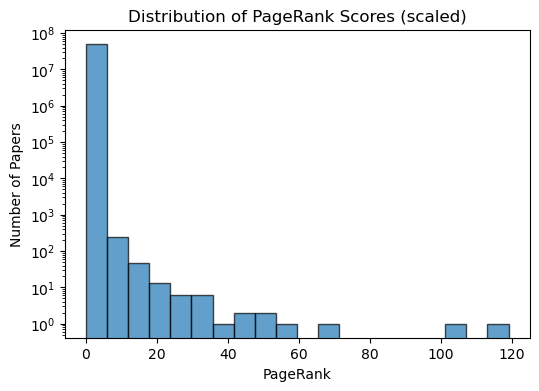

In [10]:
plt.figure(figsize=(6,4))
plt.hist(df['pagerank_scaled'], bins=20, edgecolor='k', alpha=0.7)
plt.xlabel('PageRank')
plt.ylabel('Number of Papers')
plt.title('Distribution of PageRank Scores (scaled)')
plt.yscale('log') 
plt.show()

In [11]:
# Turn the strings into Python lists
df['fields_list'] = (
    df['fields_of_study']
    .fillna('')  # fill NaNs with empty string
    .str.strip('{}')
    .str.split(',')
    .apply(lambda L: [x.strip().strip('"').strip("'") for x in L if x])
)
# Pick the first element Unknown as a primary field
df['primary_field'] = df['fields_list'].apply(lambda L: L[0] if L else 'Unknown')

In [12]:
path3 = '/lustre/b192aa/b192aa36/input/citations.csv'
citations_df = pd.read_csv(path3)

In [13]:
citations_df.columns = ['citing_id', 'cited_id']

In [14]:
# Pick top 1500 by pagerank_scaled
top_1500_pagerank = df.sort_values('pagerank_scaled', ascending=False).head(1500)
top_ids = set(top_1500_pagerank['paper_id'])
print(f"Picked {len(top_ids)} top PageRank IDs")

# Filter edges to citations among those top papers
sub_edges = citations_df[
    citations_df['citing_id'].isin(top_ids) &
    citations_df['cited_id'].isin(top_ids)
].copy()

# Identify which top_ids actually appear in edges
connected_ids = set(sub_edges['citing_id']).union(sub_edges['cited_id'])
print(f"{len(connected_ids)} of those are actually connected")

# Build directed graph
G_small = nx.from_pandas_edgelist(
    sub_edges,
    source='citing_id',
    target='cited_id',
    create_using=nx.DiGraph()
)

# Prepare color mapping by field
field_map = df.set_index('paper_id')['primary_field'].to_dict()
fields = sorted({field_map.get(n, 'Unknown') for n in connected_ids})
cmap = plt.get_cmap('tab20')
field2color = {
    fld: "#{:02x}{:02x}{:02x}".format(
        *(int(255 * c) for c in cmap(i / len(fields))[:3])
    ) for i, fld in enumerate(fields)
}

# Map pagerank_scaled for connected nodes and apply log scaling
pagerank_map = df.set_index('paper_id')['pagerank_scaled'].to_dict()
pr_scores = np.array([pagerank_map.get(n, 0) for n in G_small.nodes()])

# Add small epsilon to avoid log(0)
epsilon = 1e-6
log_pr = np.log(pr_scores + epsilon)

min_log, max_log = log_pr.min(), log_pr.max()

if max_log > min_log:
    pr_norm = (log_pr - min_log) / (max_log - min_log)
else:
    pr_norm = np.ones_like(log_pr) * 0.5  # fallback if no variation

# Increase size range for better visual contrast
min_size, max_size = 20, 100
scaled_sizes = min_size + (max_size - min_size) * pr_norm
node_sizes = dict(zip(G_small.nodes(), scaled_sizes))

# Build PyVis network
net = Network(height='800px', width='100%', directed=True)

for n in G_small.nodes():
    fld = field_map.get(n, 'Unknown')
    pr_score = pagerank_map.get(n, 0)
    size = node_sizes.get(n, min_size)
    net.add_node(
        n,
        label=str(n),
        title=f"ID: {n} Field: {fld} PageRank: {pr_score:.6f}",
        color=field2color[fld],
        size=size
    )

for u, v in G_small.edges():
    net.add_edge(u, v)

# Export and display
net.write_html("top1500_pagerank_connected.html")
display(IFrame(src="top1500_pagerank_connected.html", width="100%", height="800px"))


Picked 1500 top PageRank IDs
831 of those are actually connected


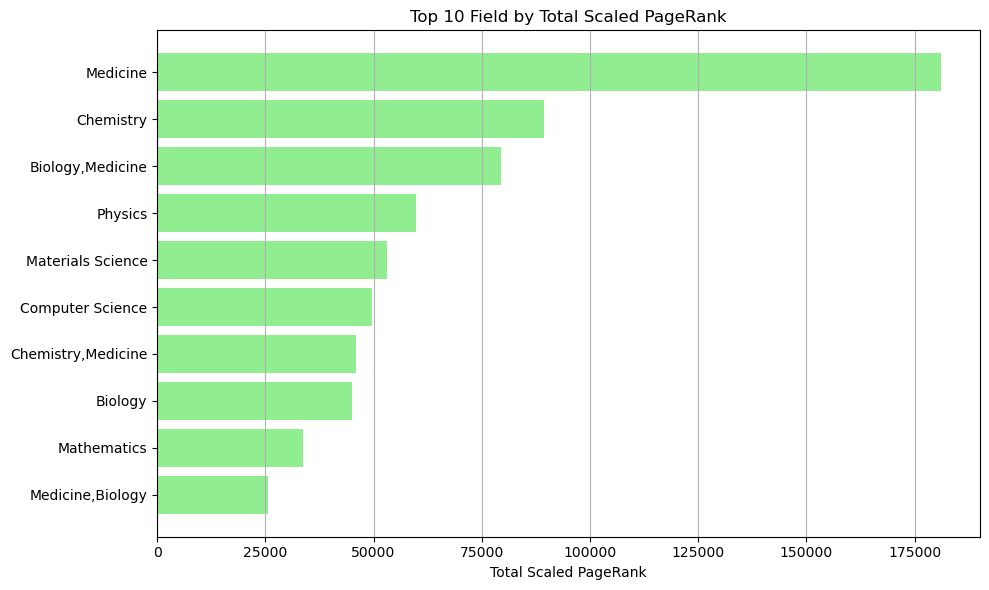

In [15]:
summary = (
    df
    .groupby('fields_of_study', sort=False)
    .agg(
        total_pagerank_scaled=('pagerank_scaled', 'sum'),
        avg_pagerank_scaled=('pagerank_scaled', 'mean'),
        paper_count=('paper_id', 'count')
    )
    .sort_values('total_pagerank_scaled', ascending=False)
    .reset_index()
)

# === Plot ===
top_n = summary.head(10)

plt.figure(figsize=(10, 6))
plt.barh(top_n['fields_of_study'], top_n['total_pagerank_scaled'], color='lightgreen')
plt.xlabel("Total Scaled PageRank")
plt.title("Top 10 Field by Total Scaled PageRank")
plt.gca().invert_yaxis()
plt.grid(True, axis='x')
plt.tight_layout()
plt.show()

In [18]:
# Ensure IDs are string and trimmed for exact matching
citations_df['cited_id'] = citations_df['cited_id'].astype(str).str.strip()
df['paper_id'] = df['paper_id'].astype(str).str.strip()

base_url = "https://www.semanticscholar.org/paper/"

citation_counts = citations_df['cited_id'].value_counts().rename('citation_count')

df_with_citations = df.merge(citation_counts, how='left', left_on='paper_id', right_index=True)
df_with_citations['citation_count'] = df_with_citations['citation_count'].fillna(0).astype(int)

# Normalize values between 0 and 1
df_with_citations['pagerank_norm'] = (
    (df_with_citations['pagerank_scaled'] - df_with_citations['pagerank_scaled'].min())
    / (df_with_citations['pagerank_scaled'].max() - df_with_citations['pagerank_scaled'].min())
)

df_with_citations['citations_norm'] = (
    (df_with_citations['citation_count'] - df_with_citations['citation_count'].min())
    / (df_with_citations['citation_count'].max() - df_with_citations['citation_count'].min())
)

# Thresholds
high_pr_thresh = df_with_citations['pagerank_norm'].quantile(0.90)
low_cit_thresh = df_with_citations['citations_norm'].quantile(0.10)

low_pr_thresh = df_with_citations['pagerank_norm'].quantile(0.10)
high_cit_thresh = df_with_citations['citations_norm'].quantile(0.90)

# 1. High PageRank, Low Citations
high_pr_low_cit = df_with_citations[
    (df_with_citations['pagerank_norm'] >= high_pr_thresh) &
    (df_with_citations['citations_norm'] <= low_cit_thresh)
]

# 2. Low PageRank, High Citations
low_pr_high_cit = df_with_citations[
    (df_with_citations['pagerank_norm'] <= low_pr_thresh) &
    (df_with_citations['citations_norm'] >= high_cit_thresh)
]

# 1. Prepare High PageRank, Low Citations table
high_pr_low_cit_display = high_pr_low_cit[['paper_id', 'pagerank_scaled', 'citation_count', 'rank']].head(10).copy()
high_pr_low_cit_display['paper_id'] = high_pr_low_cit_display['paper_id'].apply(
    lambda pid: f'<a href="{base_url}{pid}" target="_blank">{pid}</a>'
)

# 2. Prepare Low PageRank, High Citations table
low_pr_high_cit_display = low_pr_high_cit[['paper_id', 'pagerank_scaled', 'citation_count', 'rank']].head(10).copy()
low_pr_high_cit_display['paper_id'] = low_pr_high_cit_display['paper_id'].apply(
    lambda pid: f'<a href="{base_url}{pid}" target="_blank">{pid}</a>'
)

# Display both
print("🔹 High PageRank, Low Citations:")
display(HTML(high_pr_low_cit_display.to_html(escape=False, index=False)))

print("🔸 Low PageRank, High Citations:")
display(HTML(low_pr_high_cit_display.to_html(escape=False, index=False)))

🔹 High PageRank, Low Citations:


paper_id,pagerank_scaled,citation_count,rank
d97b6883d73a03d92e2c6c7de758022b5d72ea27,0.03,1,3101209
b53340f87681878d5678b2f234a70514d77c10d9,0.03,1,4368375
5352d99128ba218f028a724caebb8796c45c74a6,0.03,1,4994686
26d548fe032d52e7c4676f3705c48dad7ede9cdd,0.03,1,4030401
7d878501c8f7e4c41bbbf94c7d427a2574a48d18,0.03,1,4650363
42a29340e7e2a8711cd2c0ebdcc7dcba2fc646b2,0.03,1,4768493
98be2e66e9b21979d24c37d7ffb972cbf1a07eac,0.03,1,3014994
62b3a85b230a9be376b89861e6524e6cd3fc73ad,0.10,1,410339
8443ffecdcfb89195a023ddf8bcd328b040771fe,0.03,1,5067662
47363080e5664f1aabf9d7e585db830c8456c455,0.03,1,4443381


🔸 Low PageRank, High Citations:


paper_id,pagerank_scaled,citation_count,rank
3aca07bbdbefa484bfd480546cffac1c4b9a6afc,0.01,31,25910383
575aa9a54e9fd83e56d1a25f11fff272aaa62b65,0.01,24,26752388
02108019afa7e9d0a16f5b0a394e580904e3abae,0.01,25,29678967
54fb7e369e1cbafb1983b0d0df23b049b7a46f1c,0.01,23,24185873
0a1e709d93058ce80aa495dbe294d729191f9f92,0.01,22,31970350
76f59e2dd18428809ae8f6261af3581347d0e484,0.01,26,25020784
bec4db67335b6971963c3aff93b64287cb19f528,0.01,24,29950467
7a7841c9762bacd14f63479d8296eea85d94b9a3,0.01,26,30674111
23caee090f5043fd49f4fdcc90ab69b6ba554de6,0.01,23,33636675
3e173020e48d3d942e26bd66d2546aaec4e5ff6a,0.01,22,35728562


## Professors

In [7]:
# Merge based on matching paper IDs
professor_papers = professors_df.merge(
    df[['paper_id', 'pagerank_scaled']],     # keep only needed columns
    left_on='paperId',
    right_on='paper_id',
    how='inner'  # only keep matches
)

# Optional: drop duplicate 'paper_id' column if not needed
professor_papers = professor_papers.drop(columns=['paper_id'])

# Preview
professor_papers.head()

,authorId,authorName,paperId,title,fieldsOfStudy,pagerank_scaled
0,50706060,M. Oliver,077fba5d29c3c1ad0057c5f508dd7bad4a60d8aa,On the Relation between Fourier and Walsh--Rad...,NaN,0.01
1,50706060,M. Oliver,15ceedba62972fa35ec93940e2922dc400b36b5a,Quasi-convergence of an implementation of opti...,"['Computer Science', 'Mathematics']",0.01
2,50706060,M. Oliver,0330e08894fae75efc6509970d2a8e97fa0b2ef6,Variational balance models for the three-dimen...,"['Mathematics', 'Physics']",0.01
3,50706060,M. Oliver,1e784a83dafbef2d7d4467303df949694467da1e,High-order uniformly accurate time integrators...,"['Physics', 'Computer Science', 'Mathematics']",0.01
4,50706060,M. Oliver,59c113fcd23630bfc3233c597ab3f782bf9591dd,Optimal balance for rotating shallow water in ...,['Mathematics'],0.01


In [8]:
top_papers = (
    professor_papers
    .sort_values('pagerank_scaled', ascending=False)
    .head(30)
)

print(top_papers[['authorName', 'title', 'pagerank_scaled']])

          authorName                                              title  \
53         M. Oliver  Analyticity of Solutions for a Generalized Eul...   
143        T. Janjić  Survey of data assimilation methods for convec...   
56         M. Oliver  Length scales in solutions of the complex Ginz...   
57         M. Oliver  Global well-posedness for models of shallow wa...   
251           N. Ray                           Microaggregates in soils   
202       G. Pfander                  Gabor Frames in Finite Dimensions   
224       G. Pfander        Measurement of Time-Variant Linear Channels   
226       G. Pfander  Identification of Operators with Bandlimited S...   
50         M. Oliver  THE VORTEX BLOB METHOD AS A SECOND-GRADE NON-N...   
222       G. Pfander         Sparsity in Time-Frequency Representations   
216       G. Pfander  Identification of Matrices Having a Sparse Rep...   
169        T. Janjić  Treatment of Observation Error due to Unresolv...   
146        T. Janjić   On

In [9]:
prof_rank_summary = (
    professor_papers
    .groupby('authorName')
    .agg(
        pagerank_mean=('pagerank_scaled', 'mean'),
        pagerank_sum=('pagerank_scaled', 'sum')
    )
    .reset_index()
    .sort_values('pagerank_mean', ascending=False)
)

In [12]:
prof_rank_summary_sum = (
    prof_rank_summary[['authorName', 'pagerank_sum']]
    .copy()
    .rename(columns={'authorName': 'Professor', 'pagerank_sum': 'Total PageRank'})
)
prof_rank_summary_sum['Total PageRank'] = prof_rank_summary_sum['Total PageRank'].round(2)
prof_rank_summary_sum['Rank'] = prof_rank_summary_sum['Total PageRank'].rank(method='dense', ascending=False).astype(int)

display(prof_rank_summary_sum.sort_values('Rank').head(10))

,Professor,Total PageRank,Rank
3,M. Oliver,0.98,1
2,G. Pfander,0.96,2
6,T. Janjić,0.82,3
1,F. Voigtlaender,0.50,4
4,N. Ray,0.43,5
7,Thomas Setzer,0.37,6
5,P. Fontaine,0.25,7
0,Dominik Stöger,0.22,8


In [14]:
prof_rank_summary_mean = (
    prof_rank_summary[['authorName', 'pagerank_mean']]
    .copy()
    .rename(columns={'authorName': 'Professor', 'pagerank_mean': 'PageRank Mean'})
)
prof_rank_summary_mean['PageRank Mean'] = prof_rank_summary_mean['PageRank Mean'].round(4)
prof_rank_summary_mean['Rank'] = prof_rank_summary_mean['PageRank Mean'].rank(method='dense', ascending=False).astype(int)

display(prof_rank_summary_mean.sort_values('Rank').head(10))

,Professor,PageRank Mean,Rank
3,M. Oliver,0.0163,1
6,T. Janjić,0.0158,2
2,G. Pfander,0.0157,3
0,Dominik Stöger,0.0138,4
4,N. Ray,0.0134,5
1,F. Voigtlaender,0.0128,6
7,Thomas Setzer,0.0123,7
5,P. Fontaine,0.0119,8
